# Evaluate predictions of emergency demand

The previous notebook demonstrated the full implementation in code of training models for use at UCLH using the functions provided in `patientflow`. 

The final step is to evaluate the predicted distributions against observed numbers. I will evaluate the predictions by specialty, using the qq plot approach covered in a previous notebook.

As the predictions for yet-to-arrive patients are aspirational, these cannot be evaluated against observed numbers of admissions in the prediction window. Similarly for the group of patients in the ED, we calculate the predicted number of beds needed within the prediction window, but due to poor ED performance, few may have been admitted within the window.

We can, however, evaluate the predictions of beds needed for each specialty against observed numbers admitted to each specialty from among patients comprising each group snapshot. For the yet-to-arrive patients, we can evaluate the arrival rates learned from the training set against observed arrival rates in the test set. 

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()


Inferred project root: /Users/zellaking/Repos/patientflow


## Set file paths and load data

I'm going to use real patient data from UCLH to demonstrate the implementation. 

You can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.

In [3]:
from patientflow.load import set_file_paths

# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
    project_root, 
    data_folder_name=data_folder_name,
    config_file = 'config.yaml')

Configuration will be loaded from: /Users/zellaking/Repos/patientflow/config.yaml
Data files will be loaded from: /Users/zellaking/Repos/patientflow/data-public
Trained models will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public
Images will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public/media


In [104]:
import pandas as pd
from patientflow.load import load_data

# load ED snapshots data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date

# load data on inpatient arrivals
inpatient_arrivals = inpatient_arrivals = load_data(data_file_path, 
                    file_name='inpatient_arrivals.csv')
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)


## Set modelling parameters

The parameters are used in training or inference. They are set in config.json in the root of the repository and loaded by `load_config_file()`

In [6]:
# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]


## Apply temporal splits

In [105]:
from patientflow.prepare import create_temporal_splits

train_visits_df, valid_visits_df, test_visits_df = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

train_inpatient_arrivals_df, _, test_inpatient_arrivals_df = create_temporal_splits(
    inpatient_arrivals,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="arrival_datetime",
)

Split sizes: [53801, 6519, 19494]
Split sizes: [7730, 1244, 3701]


## Train models to predict bed count distributions for patients currently in the ED

This time I'll use a larger parameter grid, while still limiting the search space to a few hyperparameters for expediency.

In [9]:

from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

grid = { # Current parameters
    'n_estimators': [30, 40, 50],  # Number of trees
    'subsample': [0.7, 0.8, 0.9],  # Sample ratio of training instances
    'colsample_bytree': [0.7, 0.8, 0.9],  # Sample ratio of columns for each tree
   } 

exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

ordinal_mappings = {
    "latest_acvpu": ["A", "C", "V", "P", "U"],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe\\E\\Very Severe",
    ],
    "latest_obs_level_of_consciousness": ["A", "C", "V", "P", "U"],
}

# create a dictionary to store the trained models
admissions_models = {}
model_name = 'admissions'

# Loop through each prediction time
for prediction_time in ed_visits.prediction_time.unique():
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits_df,
        valid_visits=valid_visits_df,
        test_visits=test_visits_df,
        grid=grid,
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_key = get_model_key(model_name, prediction_time)
    
    admissions_models[model_key] = model

Training model for (12, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (9, 30)
Training model for (22, 0)


## Train specialty model

Here the `apply_special_category_filtering` parameter has been set to True, so it will be assumed that all patients under 18 on arrival will be admitted to a paediatric specialty. 

In [10]:
from patientflow.predictors.sequence_predictor import SequencePredictor

spec_model = SequencePredictor(
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    apply_special_category_filtering=True,
)

spec_model = spec_model.fit(train_visits_df)

## Train models for yet-to-arrive patients



In [106]:
from patientflow.predictors.weighted_poisson_predictor import WeightedPoissonPredictor
from patientflow.prepare import create_yta_filters

x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = params["prediction_window"]
yta_time_interval = params["yta_time_interval"]

specialty_filters = create_yta_filters(ed_visits)
yta_model_by_spec =  WeightedPoissonPredictor(filters = specialty_filters, verbose=False)

# calculate the number of days between the start of the training and validation sets; used for working out daily arrival rates
num_days = (start_validation_set - start_training_set).days

if 'arrival_datetime' in train_inpatient_arrivals_df.columns:
    train_inpatient_arrivals_df.set_index('arrival_datetime', inplace=True)

yta_model_by_spec =yta_model_by_spec.fit(train_inpatient_arrivals_df, 
              prediction_window=prediction_window, 
              yta_time_interval=yta_time_interval, 
              prediction_times=ed_visits.prediction_time.unique(), 
              num_days=num_days )

## Generate predicted distributions for each specialty and prediction time for patients in ED

As we are treating paediatric patients differently from adults, the code below includes logic to identify eligible snapshots in either case. 

When evaluating the predictions for adult destinations (medical, surgical and haem/onc), patients under 18 will be excluded. When evaluating the predictions for paediatric patients, adults will be excluded.

In [ ]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict
from patientflow.aggregate import get_prob_dist
from patientflow.predict.emergency_demand import get_specialty_probs

prob_dist_dict_all = {}
specialties = ['medical', 'surgical', 'haem/onc', 'paediatric']

special_params = spec_model.special_params

special_category_func = special_params["special_category_func"]
special_category_dict = special_params["special_category_dict"]
special_func_map = special_params["special_func_map"]

# Get predictions of admission to specialty
test_visits_df.loc[:, "specialty_prob"] = get_specialty_probs(
    specialties,
    spec_model,
    test_visits_df,
    special_category_func=special_category_func,
    special_category_dict=special_category_dict,
)

# initialise a dictionary to store the probability distributions for each specialty and prediction time
prob_dist_dict_all = {}

# Process each time of day
for _prediction_time in ed_visits.prediction_time.unique():

    prob_dist_dict_for_pats_in_ED = {}

    print("\nProcessing :" + str(_prediction_time))
    model_key = get_model_key(model_name, _prediction_time)
    
    for specialty in specialties:
        print(f"Predicting bed counts for {specialty} specialty, for all snapshots in the test set")
        prob_dist_dict_for_specialty = {}

        # Get indices of patients who are eligible for this specialty
        func = special_func_map.get(specialty, special_func_map["default"])
        non_zero_indices = test_visits_df[
            test_visits_df.apply(func, axis=1)
        ].index

        test_df_eligible = test_visits_df.copy()
        test_df_eligible = test_df_eligible.loc[non_zero_indices]

        # get the probability of admission to the specialty for eligible patients
        # for patients under 18, the probability of admission to paediatric is 1
        prob_admission_to_specialty = test_df_eligible["specialty_prob"].apply(
            lambda x: x[specialty]
        )

        # Prepare patient snapshots for the eligible patients
        X_test, y_test = prepare_patient_snapshots(
            df=test_df_eligible, 
            prediction_time=_prediction_time, 
            single_snapshot_per_visit=False,
            exclude_columns=exclude_from_training_data, 
            visit_col='visit_number'
        )

        # filter the probability of admission to the specialty for the eligible patients
        filtered_prob_admission_to_specialty = prob_admission_to_specialty.loc[
            non_zero_indices
        ]

        group_snapshots_dict = prepare_group_snapshot_dict(
            test_df_eligible[test_df_eligible.prediction_time == _prediction_time]
        )

        admitted_to_specialty = test_df_eligible['specialty'] == specialty

        # get probability distribution for this time of day, for this specialty, for patients in ED
        prob_dist_dict_for_pats_in_ED[specialty] = get_prob_dist(
            group_snapshots_dict, X_test, y_test, admissions_models[model_key], 
            weights=filtered_prob_admission_to_specialty,
            category_filter=admitted_to_specialty
            ) 
        

    prob_dist_dict_all[f'{model_key}'] = prob_dist_dict_for_pats_in_ED



Processing :(12, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(15, 30)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(6, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all 

## Visualise the performance of emergency demand prediction models for patients in the ED

Below I show two ways to evaluate the predicted distributions
* histograms of observed versus expected values
* qq plots

The models perform best for medical and surgical specialties, which have more snapshots. These specialties show better calibration, particularly at 12:00 and 15:30. The 22:00 models show weak performance, which will partly be a result of the admissions model itself being worse for that time of day.

The haematology/oncology and paediatric models have stepped patterns in their QQ plots. Because these specialties admit few patients, they cause modelling challenges:

* Each admission or discharge has a larger proportional impact
* Random variations have stronger effects on daily census
* The models struggle to capture the true variability in these departments

Their QQ plots show a stepwise pattern of sharp vertical jumps. However, the narrow, peaked histograms for these specialties suggest consistent, small overestimations rather than wild inaccuracy, which is actually a reasonable outcome given the small sample sizes. 

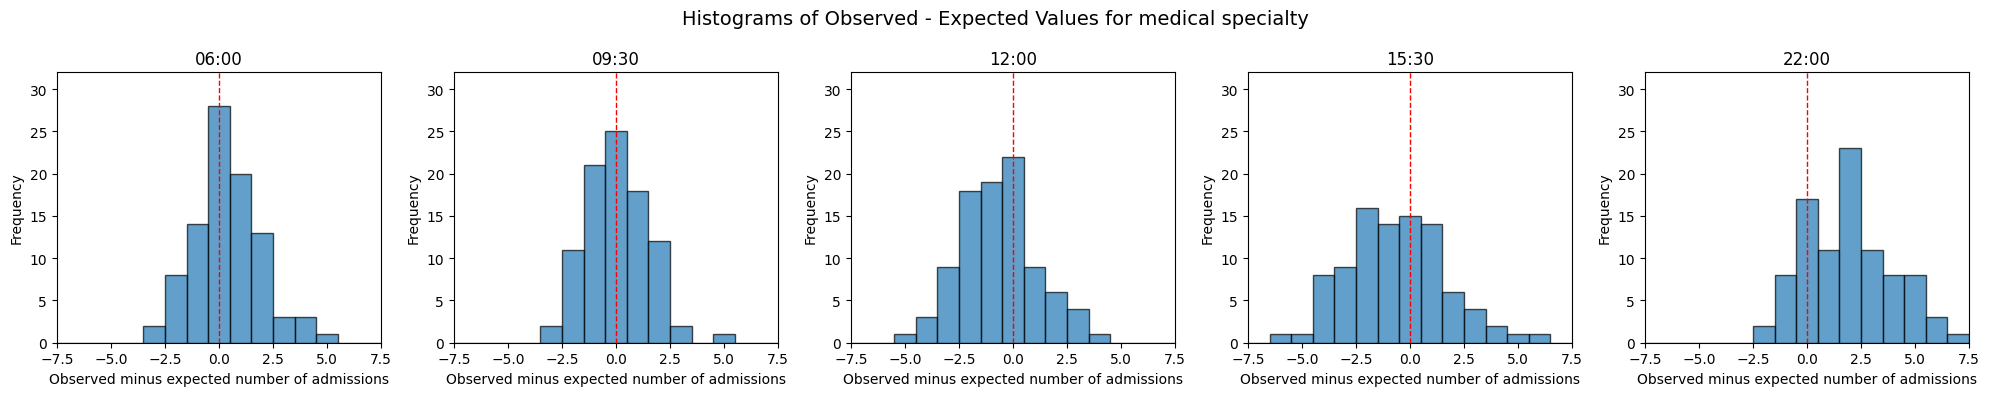

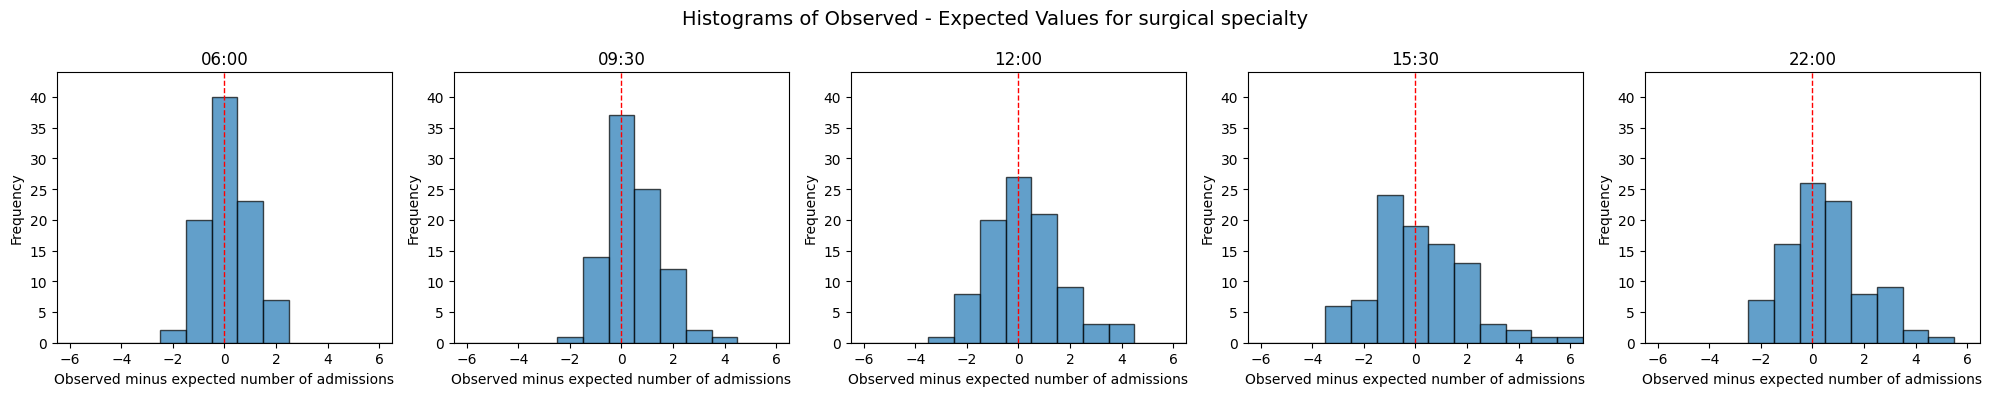

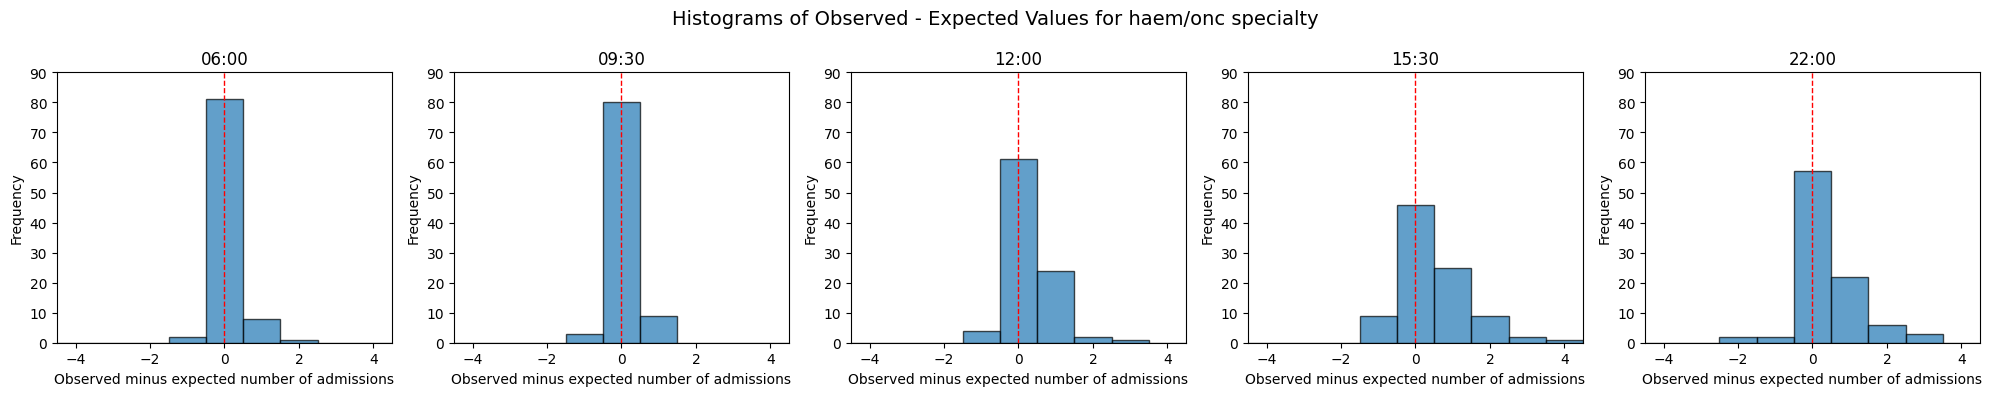

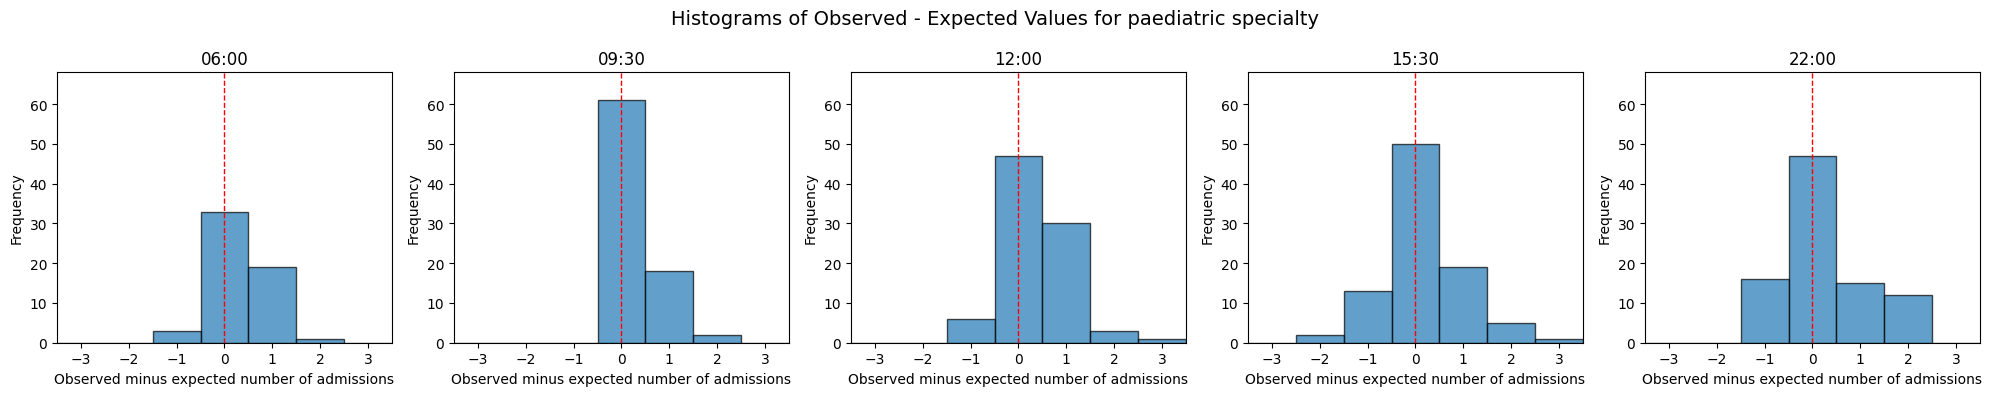

In [101]:
from patientflow.evaluate import calc_mae_mpe
from patientflow.viz.evaluation_plots import plot_observed_against_expected

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}
    results = calc_mae_mpe(specialty_prob_dist)
    plot_observed_against_expected(results, 
                                   main_title=f"Histograms of Observed - Expected Values for {specialty} specialty",)


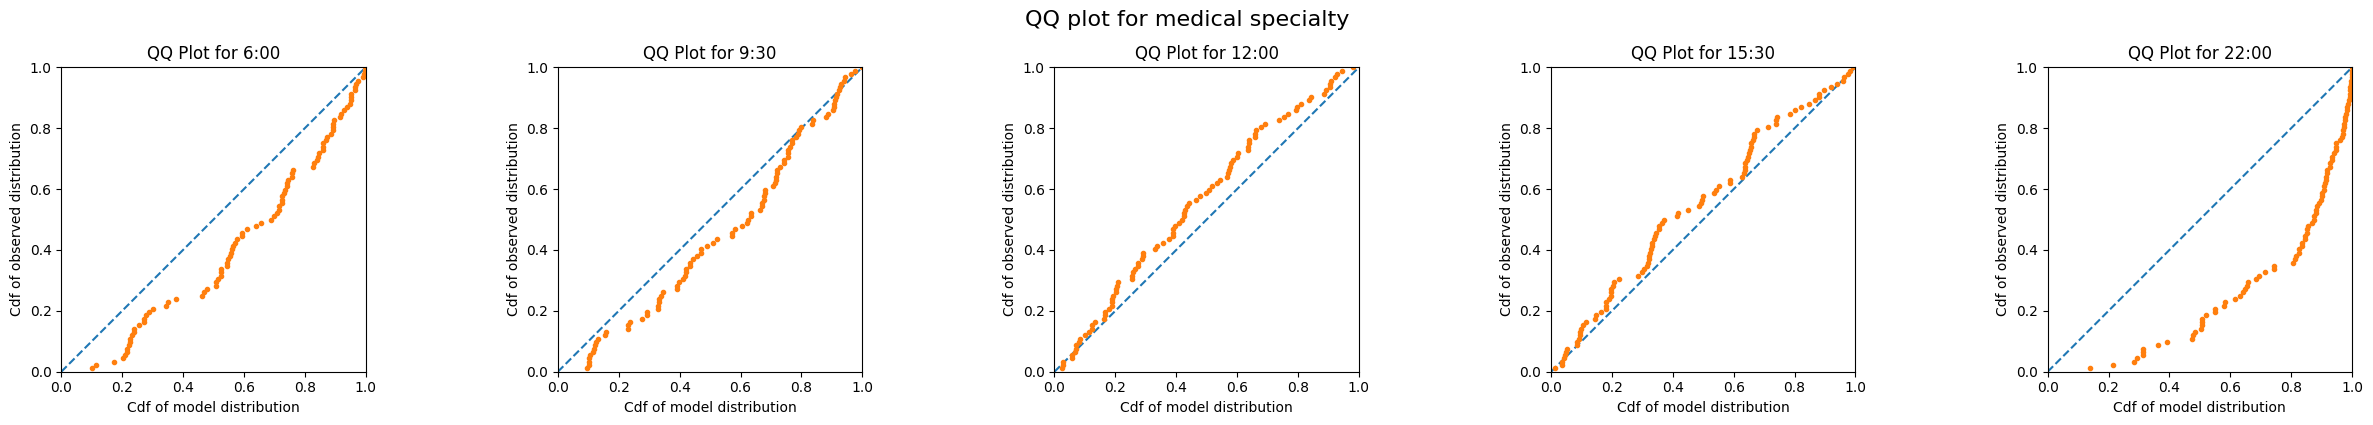

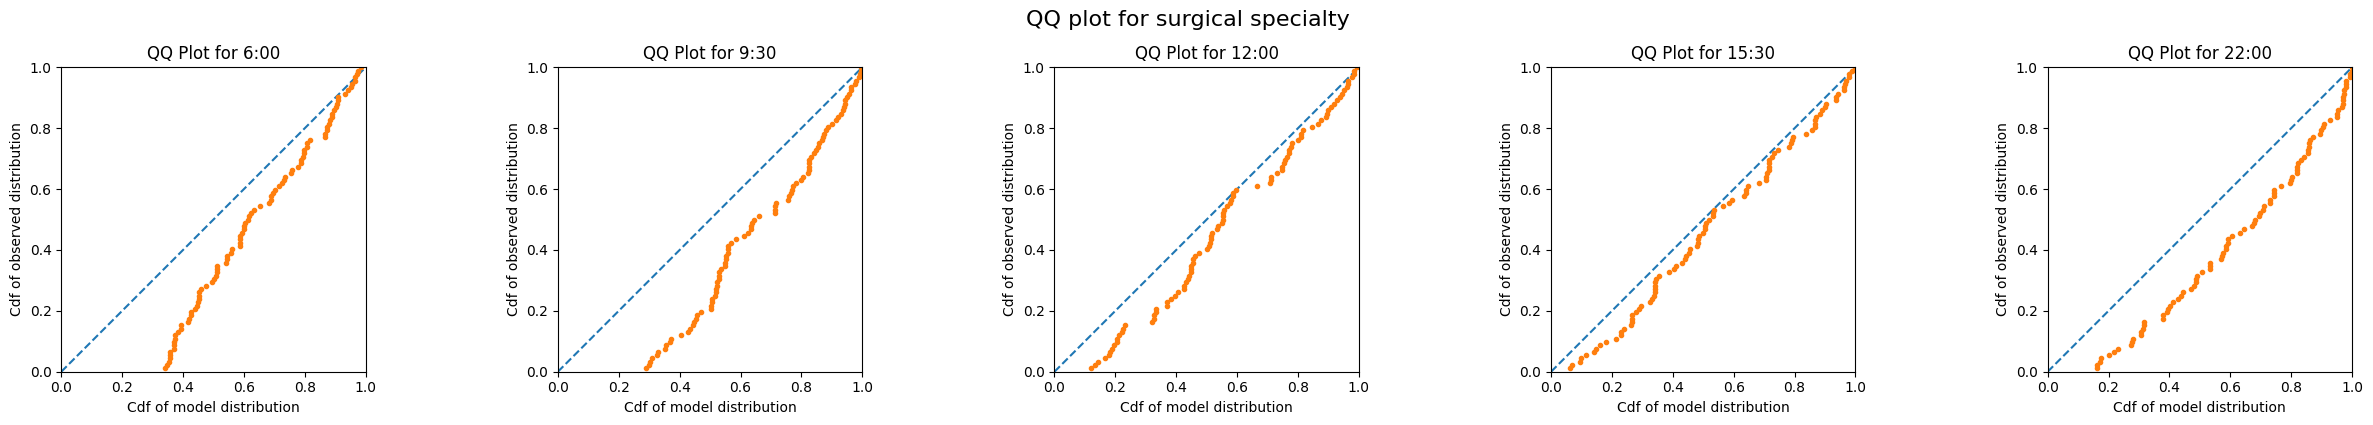

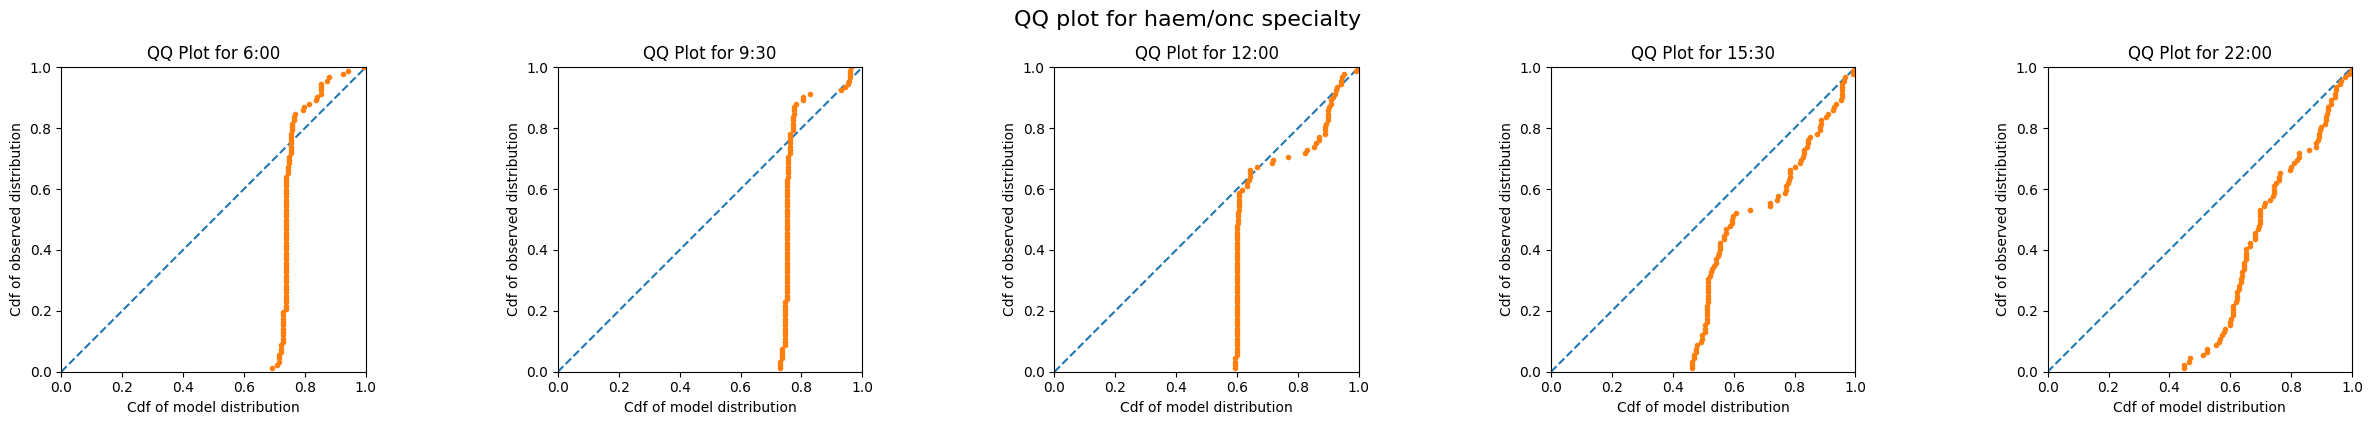

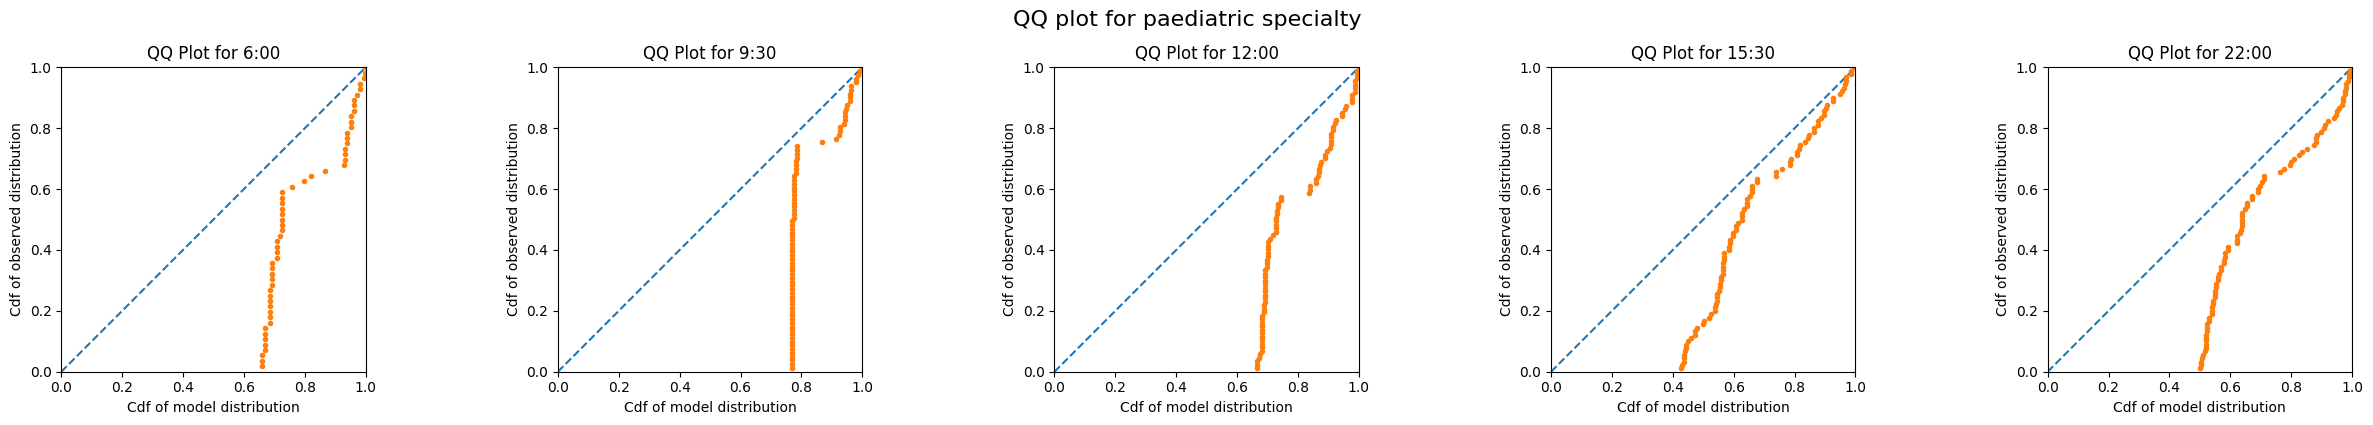

In [ ]:
from patientflow.viz.qq_plot import qq_plot

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}

    qq_plot(ed_visits.prediction_time.unique(), 
            specialty_prob_dist,
            model_name="admissions",
            suptitle=f"QQ plot for {specialty} specialty")

## ## Generate predicted distributions and observed number of admissions for each specialty and prediction time for patients yet-to-arrive to the ED

As the predictions for yet-to-arrive patients are aspirational, these cannot be directly compared with observed numbers of patients who arrived after the moment of prediction, and were admitted within the prediction window. Due to slower than target processing of patients through the ED, these future arrivals would have a smaller likelihood of being admitted within the window than suggested by the aspirational target. 

We can, however, compare the predictions based on arrival rates at the front door of ED, that were learned from the training set, against observed arrival rates at the front door during the test set. The observed arrivals can be adjusted using the same time-dependent probability of admission during the window. I have used a deterministic weighting where each patient contributes fractionally to the total number of admissions, based on their arrival time. If for example a patient arriving 3 hours into the prediction window has a 0.8 probability of admission, they would contribute 0.8 to the weighted observed count.

The function `get_prob_dist_without_patient_snapshots` saves a predicted distribution for each prediction moment in the test set, and the weighted observed count of patients later admitted who arrived during the prediction window.


In [224]:
from patientflow.aggregate import get_prob_dist_without_patient_snapshots
from datetime import timedelta


# Create date range
snapshot_dates = []
start_date = start_test_set
end_date = end_test_set

current_date = start_date
while current_date < end_date:
    snapshot_dates.append(current_date)
    current_date += timedelta(days=1)

prob_dist_dict_for_yta = {}

# Process each time of day
for _prediction_time in ed_visits.prediction_time.unique():

    print("\nProcessing :" + str(_prediction_time))
    model_key = get_model_key('yta', _prediction_time)

    prob_dist_dict_for_yta[model_key] =  get_prob_dist_without_patient_snapshots(
        prediction_time=_prediction_time, 
        categories=specialties, 
        model=yta_model_by_spec, 
        test_df=test_inpatient_arrivals_df, 
        prediction_window=prediction_window, 
        x1=x1, y1=y1, x2=x2, y2=y2, 
        snapshot_dates=snapshot_dates,
        datetime_col='arrival_datetime')


Processing :(12, 0)

Processing :(15, 30)

Processing :(6, 0)

Processing :(9, 30)

Processing :(22, 0)


In [196]:
from patientflow.calculate.admission_in_prediction_window import calculate_probability
calculate_probability (elapsed_los_td_hrs=3, prediction_window_hrs=2, x1=4, y1=0.76, x2=12, y2=0.99)
# get_admission_probability(test_inpatient_arrivals_df, snapshot_datetime, prediction_window, 'medical')

np.float64(0.7827646669523308)

In [ ]:
def get_medical_arrival_probabilities(medical_arrivals, snapshot_datetime, prediction_window):
    
    # Calculate hours between arrival and end of prediction window
    hours_til_arrival = (medical_arrivals['arrival_datetime'] - snapshot_datetime).dt.total_seconds() / 3600
    remaining_hours_in_window = (prediction_window/60 - hours_til_arrival)
    
    # Calculate probabilities for each arrival
    probabilities = remaining_hours_in_window.apply(
        lambda x: calculate_probability(
            elapsed_los_td_hrs=0,
            prediction_window_hrs=x,
            x1=4,
            y1=0.76,
            x2=12,
            y2=0.99
        )
    )
    
    return probabilities.sum()

medical_arrivals = test_inpatient_arrivals_df[
        (test_inpatient_arrivals_df['arrival_datetime'] > snapshot_datetime) & 
        (test_inpatient_arrivals_df['arrival_datetime'] <= snapshot_datetime + timedelta(minutes=prediction_window)) &
        (test_inpatient_arrivals_df.specialty == 'medical')
    ]

get_medical_arrival_probabilities(medical_arrivals, snapshot_datetime, prediction_window)



np.float64(8.806180971178536)

In [219]:
calculate_probability(
            elapsed_los_td_hrs=0,
            prediction_window_hrs=0.195833,
            x1=4,
            y1=0.76,
            x2=12,
            y2=0.99
        )

np.float64(0.002385645902756873)

## Visualise the performance of emergency demand prediction models for patients yet-to-arrive to the ED

Using the same visualisation methods as above, for ease of comparison, we can evaluate whether the arrival rates at the front door were in line with those predicted. For all specialties and prediction times, there was an underestimation. 

All the qq plots show the stepwise pattern, as well as a deviation from the reference line. 

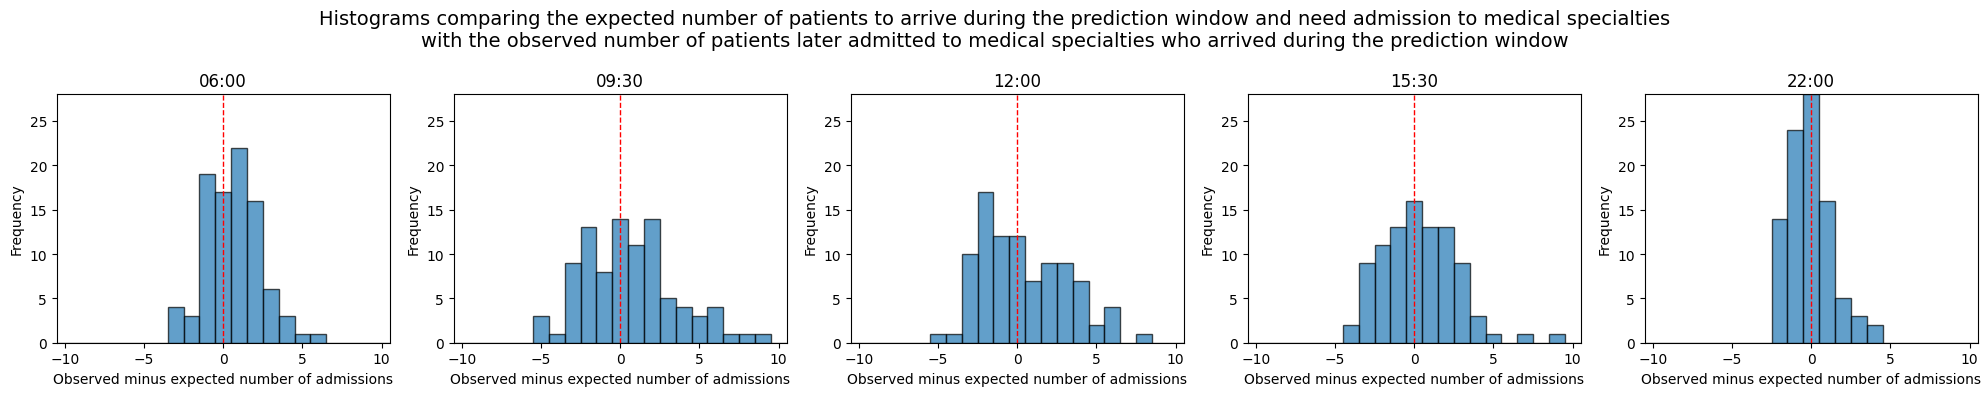

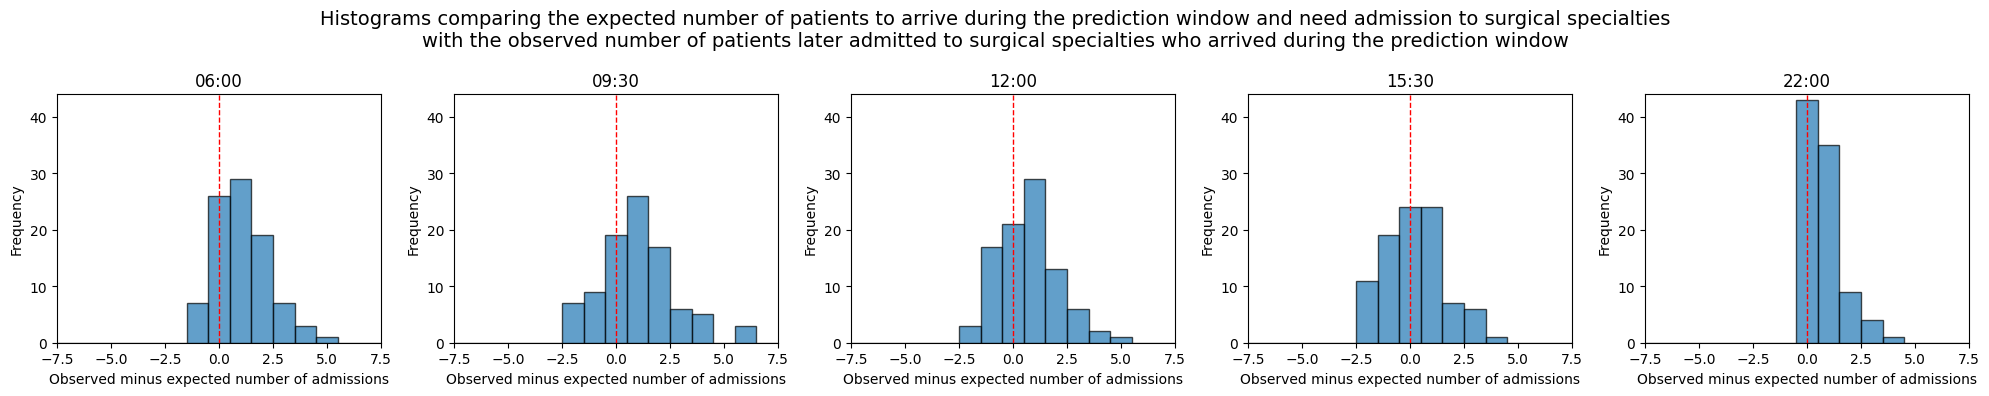

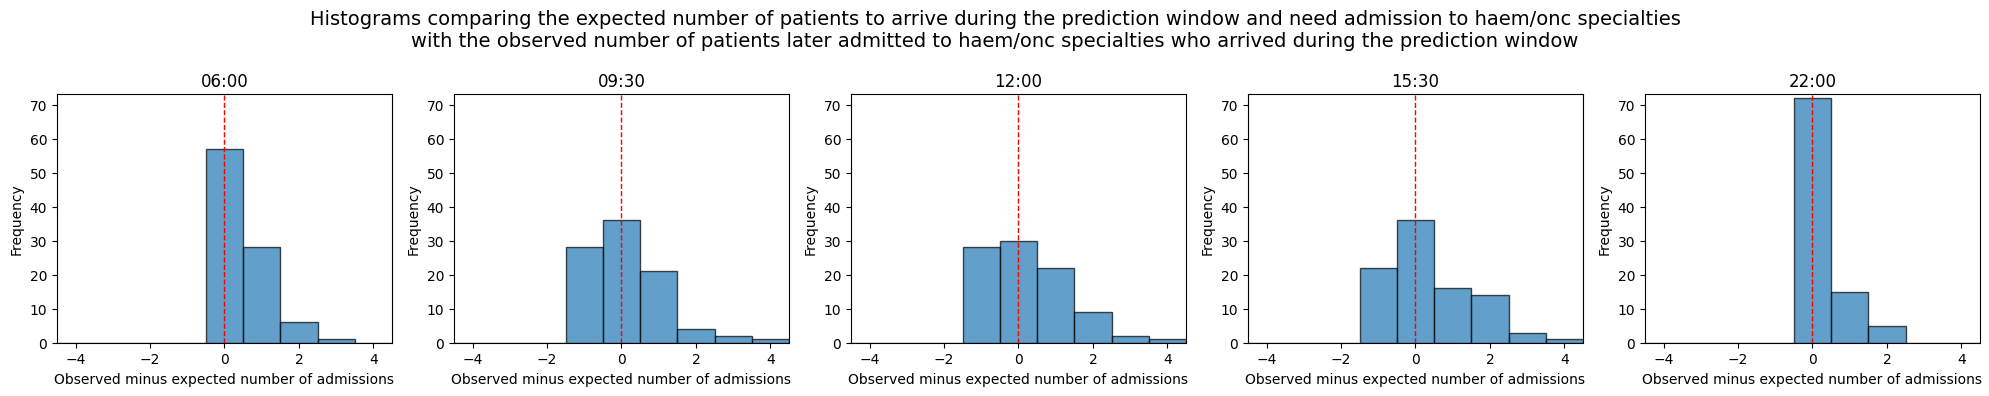

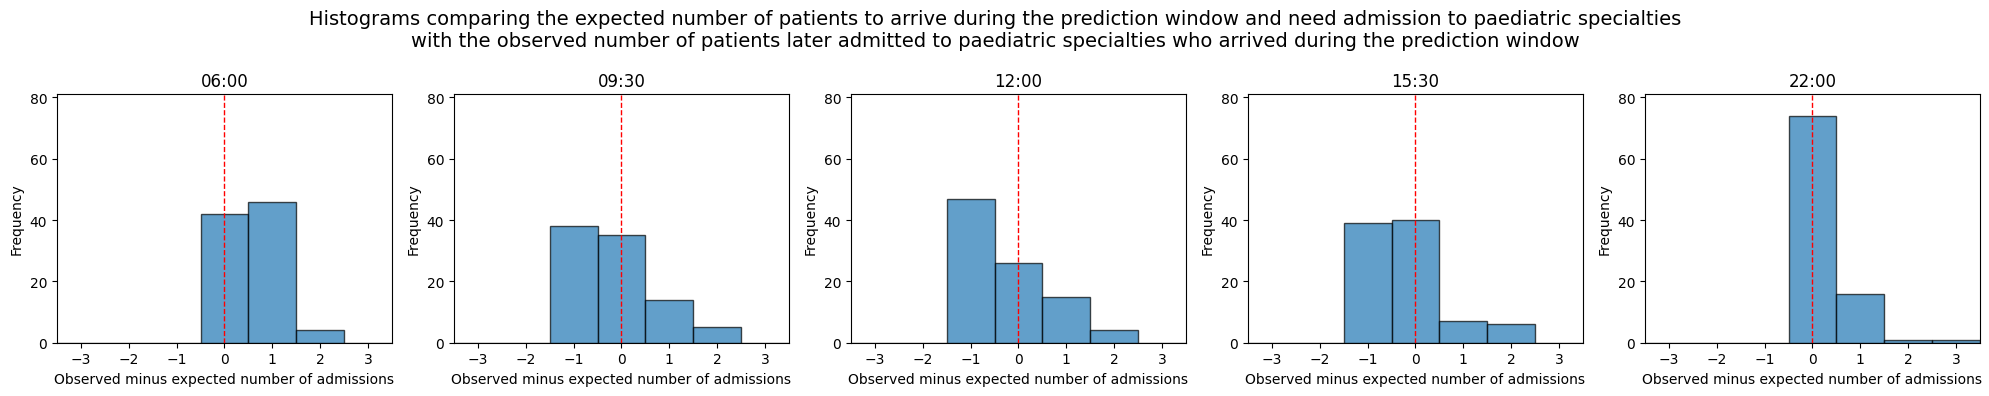

In [225]:
from patientflow.evaluate import calc_mae_mpe
from patientflow.viz.evaluation_plots import plot_observed_against_expected

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_for_yta.items()}
    results = calc_mae_mpe(specialty_prob_dist)
    plot_observed_against_expected(results, 
                                   main_title=f"Histograms comparing the expected number of patients to arrive during the prediction window and need admission to {specialty} specialties" + 
                                   f"\nwith the observed number of patients later admitted to {specialty} specialties who arrived during the prediction window")

In [228]:
specialty_prob_dist['yta_12:00']['medical']

KeyError: 'yta_12:00'

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

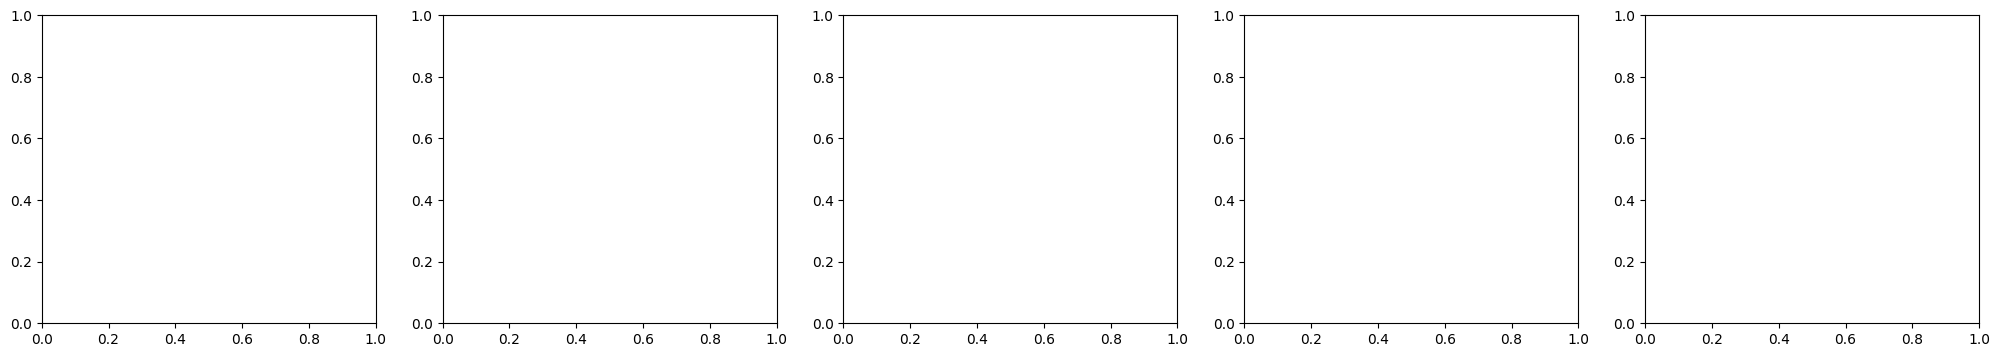

In [ ]:
from patientflow.viz.qq_plot import qq_plot

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_for_yta.items()}

    qq_plot(ed_visits.prediction_time.unique(), 
            specialty_prob_dist,
            model_name="yta",
            suptitle=f"QQ plot for patients yet-to-arrive to the ED, who need admission to {specialty} specialty")

## Conclusion

In this notebook I have shown how to evaluate predicted bed counts for the patients in ED, by specialty. I also demonstrated some of the special case handling that is in use for paediatric patients at UCLH.

The models perform best for medical and surgical specialties, which have more snapshots. These specialties show better calibration, particularly at 12:00 and 15:30. The 22:00 models show weak performance, which will partly be a result of the admissions model itself being worse for that time of day.

The haematology/oncology and paediatric models have stepped patterns in their QQ plots. Because these specialties admit few patients, they cause modelling challenges:

* Each admission or discharge has a larger proportional impact
* Random variations have stronger effects on daily census
* The models struggle to capture the true variability in these departments

Their QQ plots show a stepwise pattern of sharp vertical jumps. However, the narrow, peaked histograms for these specialties suggest consistent, small overestimations rather than wild inaccuracy, which is actually a reasonable outcome given the small sample sizes. 

Despite the challenges, the models generally center around reasonable estimates, suggesting they provide useful information for planning, though with varying degrees of precision across specialties.